In [ ]:
!pip install yfinance
# !pip install pandas-datareader
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 65.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
ybnga = yf.Ticker("BNGA.JK")

# menginput  data histori dari market data bank cimb niaga
#pengambilan data dari  tanggal 1 juli 2021 sampai  31 desember 2022
hist = ybnga.history(start="2021-07-01", end="2022-12-31")



hist.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 373 entries, 2021-07-01 00:00:00+07:00 to 2022-12-30 00:00:00+07:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          373 non-null    float64
 1   High          373 non-null    float64
 2   Low           373 non-null    float64
 3   Close         373 non-null    float64
 4   Volume        373 non-null    int64  
 5   Dividends     373 non-null    float64
 6   Stock Splits  373 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 31.4 KB


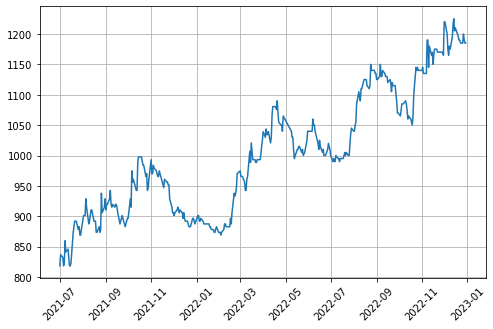

In [ ]:
fig,ax = plt.subplots(1, figsize=(8,5))
ax.plot(hist['Close'])


plt.xticks(rotation=45)
plt.grid()

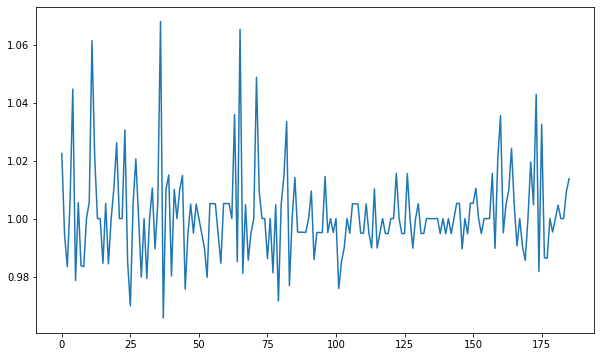

rerata, std naik 1.0154617969196593 0.015167704545255619
rerata, std turun 0.9931104860975493 0.007896012332476929
u,d,p= 1.0154617969196593 0.9931104860975493 0.3655913978494624
variansi log saham($sigma^2t$)= 0.048431095378789264


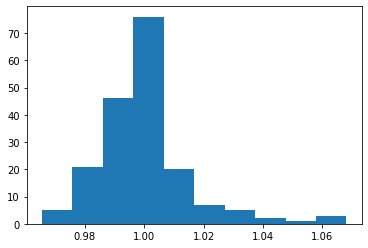

In [ ]:
# estimasi parameter metode empiris
hist['return'] = [hist.Close[i]/hist.Close[i-1] for i in range(1,len(hist))]+[0]
ret = np.array(hist['return'][0:int(len(hist)/2)])
fig,ax = plt.subplots(1,figsize=(10,6))
ax.plot(ret)
plt.show()
print('rerata, std naik', np.mean(ret[ret>1]), np.std(ret[ret>1]))
print('rerata, std turun',np.mean(ret[ret<=1]), np.std(ret[ret<=1]))
plt.hist(ret, bins=10)
naik= np.mean(ret[ret>1]) # estimasi nilai u empiris
turun = np.mean(ret[ret<=1])# estimasi nilai d emspiris
p_empi = len(ret[ret>1])/len(ret)
avret = np.mean(ret)
print('u,d,p=', naik,turun,p_empi)
# sigm=(ret-avret)**2

# estimasi MOdel CRR sigma
logS= np.log(np.array([hist.Close[i] for i in range(0,int(len(hist)/2))]))
print('variansi log saham($sigma^2t$)=', np.std(logS))
sig = np.sqrt(np.std(logS)/1)# volatilitas harga saham

In [ ]:
import math
# Pertimbangan nilai sigma dari log(S)
hist['logs'] = [np.log(k) for k in hist['Close']]
logs = np.array(hist['logs'])[0:int(len(hist)/2)+1]
varLogs=np.std(logs)**2 #\sigma^2t
sigma_Est= np.sqrt(varLogs/1)
print(len(hist['logs'][int(len(hist)/2)+1:-1]))

185


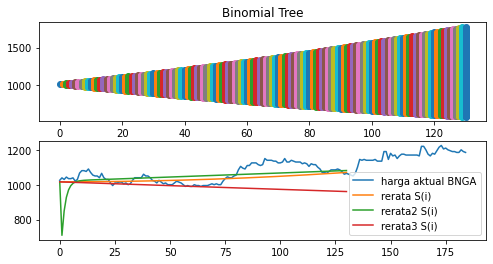

In [ ]:
# Membuat pohon Binomial Saham
So = hist.Close[int(len(hist)/2)]
sigma = sigma_Est

r = 0.055 # suku bunga bank Indonesia
N = 130 #185 # harian dalam satu tahun
dt = 1/N
u = np.exp(sigma*np.sqrt(dt))
d = 1/u
p = (np.exp(-r*dt)-d)/(u-d)

fig,ax = plt.subplots(2,figsize=(8,4))
harga = np.zeros((N+1,N+1), float)
rerata_si = np.zeros((N+1), float)
rerata2_si = np.zeros((N+1), float)
rerata3_si = np.zeros((N+1), float)
rerata_si[0] = So
rerata2_si[0] = So
rerata3_si[0] = So
harga[0,N] = So
ax[0].scatter(0, harga[0,N])
ax[1].plot(range(len(hist.Close[int(len(hist)/2)+1:-1])), hist.Close[int(len(hist)/2)+1:-1], label='harga aktual BNGA')

for i in range(1,N+1): # time step
  for j in reversed(range(i+1)): # jumlah kenaikan
    harga[j,i] = So*u**(j)*d**(i-j)
  ax[0].scatter([i for k in range(len(harga[0:i+1,i]))], harga[0:i+1,i])
  rerata_si[i] = np.mean(harga[0:i+1,i])
  prob = np.array([math.comb(i+1, i+1-k)*p**(i+1-k)*(1-p)**k for k in range(i+1)])
  # print(prob.shape,harga[0:i+1,i].shape )
  rerata2_si[i] = np.sum(harga[0:i+1,i]*prob)
  rerata3_si[i] = So*u**(i*p)*d**(i-i*p)
    # print(harga[j,i])
    # print(j)

ax[0].set_title("Binomial Tree")
ax[1].plot(rerata_si, label='rerata S(i)')
ax[1].plot(rerata2_si, label='rerata2 S(i)')
ax[1].plot(rerata3_si, label='rerata3 S(i)')
plt.legend()

In [ ]:
a = np.array([i for i in range(3)])
b = np.array([i for i in reversed(range(3))])
a*b
print(a.shape, b.shape)

(3,) (3,)


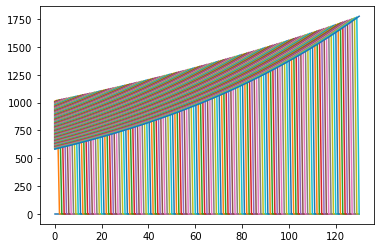

In [ ]:
plt.plot(harga)
plt.show()

MONTE CARLO

Text(0.5, 1.0, 'Harga Aktual')

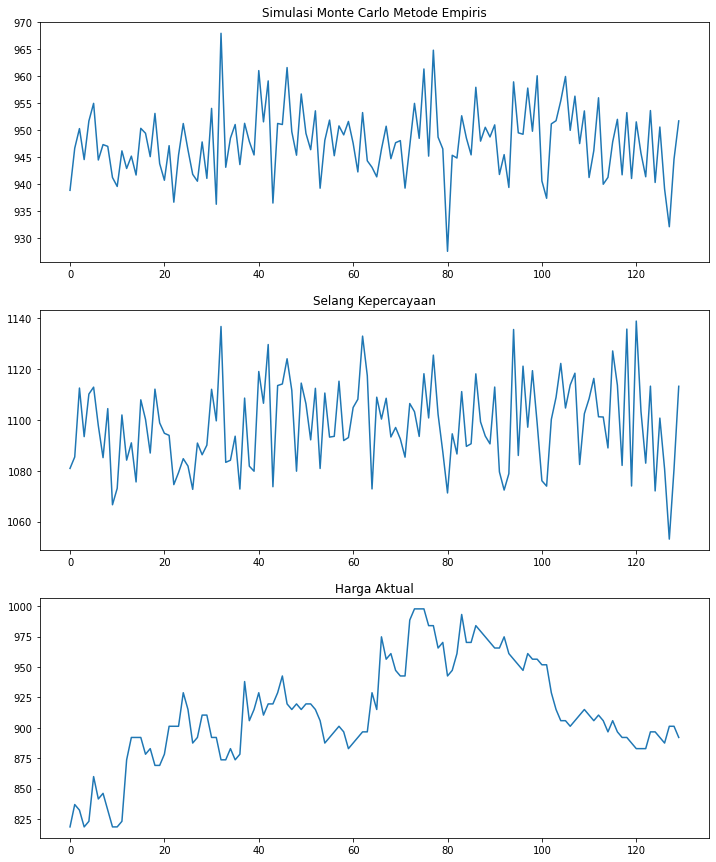

In [ ]:
# Simulasi monte carlo untuk pergerakan harga saham
s0 = hist.Close[119] # Data 12 Bulan Pertama
sigma = sigma_Est
r = 0.055 # suku bunga bank indonesia
N = 130 # jumlah hari dalam 6 bulan dengan 1 tahun = 260 hari
M = 100
dt = 1/N

#estimasi empiris
uEMP= np.mean(ret[ret>=1]) # estimasi nilai u empiris
dEMP = np.mean(ret[ret<1])# estimasi nilai d emspiris
pEMP = len(ret[ret>=1])/len(ret)

results_emp = np.zeros((M, N))

for i in range(M):
  for j in range(N):
    x = np.random.binomial(i+1, pEMP)
    results_emp[i, j] = s0 * uEMP**x * dEMP**((i+1)-x)

rata2_emp = []
for i in range(N):
  tot = 0
  for j in range(M):
    tot += results_emp[j][i]
  rata2_emp.append(tot/M)

std_emp = []
for i in range(N):
  temp = []
  for j in range(M):
    temp.append(results_emp[j][i])
  std_emp.append(np.std(temp))

selangKepercayaan_emp = []
for i in range(N):
  selangKepercayaan_emp.append(rata2_emp[i] + 1.96 * std_emp[i])

fig,ax = plt.subplots(3,figsize=(12,15))
ax[0].plot(rata2_emp)
ax[1].plot(selangKepercayaan_emp)
ax[2].plot(hist['Close'][0:130].values)
ax[0].set_title('Simulasi Monte Carlo Metode Empiris')
ax[1].set_title('Selang Kepercayaan')
ax[2].set_title('Harga Aktual')

Text(0.5, 1.0, 'Harga Aktual')

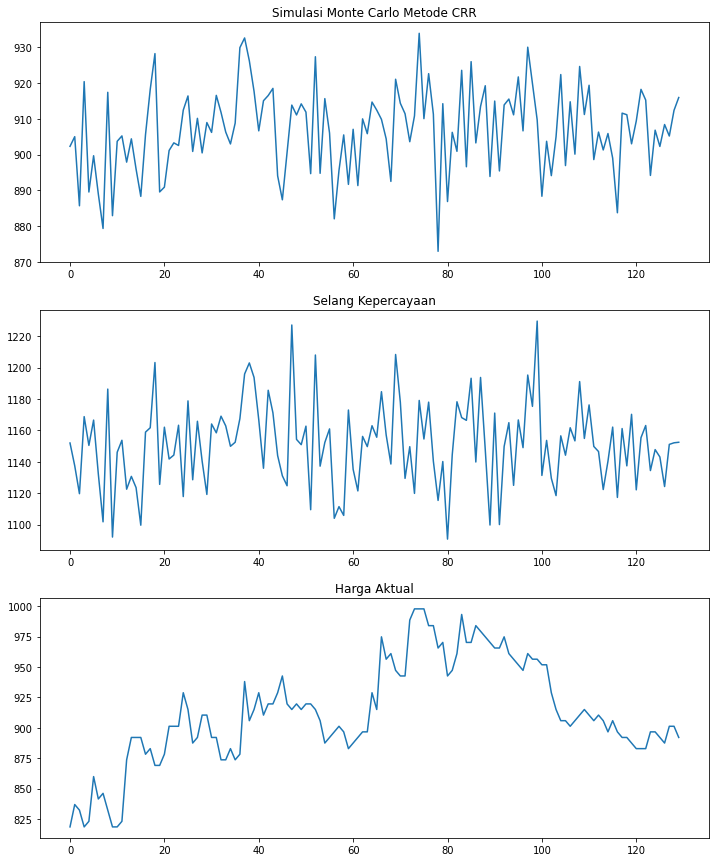

In [ ]:
# estimasi model CRR
u = np.exp(sig*np.sqrt(dt)) # faktor kenaikan harga
d = 1/u # faktor penurunan harga
p = (np.exp(r*dt)-d)/(u-d) # probabilitas kenaikan harga

results_crr = np.zeros((M, N))

for i in range(M):
  for j in range(N):
    x = np.random.binomial(i+1, p)
    results_crr[i, j] = s0 * u**x * d**((i+1)-x)

rata2_crr = []
for i in range(N):
  tot = 0
  for j in range(M):
    tot += results_crr[j][i]
  rata2_crr.append(tot/M)

std_crr = []
for i in range(N):
  temp = []
  for j in range(M):
    temp.append(results_crr[j][i])
  std_crr.append(np.std(temp))

selangKepercayaan_crr = []
for i in range(N):
  selangKepercayaan_crr.append(rata2_crr[i] + 1.96 * std_crr[i])

fig,ax = plt.subplots(3,figsize=(12,15))
ax[0].plot(rata2_crr)
ax[1].plot(selangKepercayaan_crr)
ax[2].plot(hist['Close'][0:130].values)
ax[0].set_title('Simulasi Monte Carlo Metode CRR')
ax[1].set_title('Selang Kepercayaan')
ax[2].set_title('Harga Aktual')

In [ ]:
selisih_emp = []
for i in range(N):
  selisih = rata2_emp[i] - hist['Close'][i]
  selisih_emp.append(selisih)
  print(f"Selisih harga saham empiris Sbar({i+1}): ", selisih)

print("==========================================================================")

selisih_crr = []
for i in range(N):
  selisih = rata2_crr[i] - hist['Close'][i]
  selisih_crr.append(selisih)
  print(f"Selisih harga saham CRR Sbar({i+1}): ", selisih)

Selisih harga saham empiris Sbar(1):  120.40327477565302
Selisih harga saham empiris Sbar(2):  109.8306187712518
Selisih harga saham empiris Sbar(3):  118.06519007662985
Selisih harga saham empiris Sbar(4):  126.11549706646429
Selisih harga saham empiris Sbar(5):  128.67606735896084
Selisih harga saham empiris Sbar(6):  95.16296267350128
Selisih harga saham empiris Sbar(7):  103.04266976346048
Selisih harga saham empiris Sbar(8):  101.30446737859677
Selisih harga saham empiris Sbar(9):  114.7703819675603
Selisih harga saham empiris Sbar(10):  122.78328239789471
Selisih harga saham empiris Sbar(11):  121.12504649907976
Selisih harga saham empiris Sbar(12):  123.1277976521933
Selisih harga saham empiris Sbar(13):  69.28485022290056
Selisih harga saham empiris Sbar(14):  53.183846927243735
Selisih harga saham empiris Sbar(15):  49.677839301880454
Selisih harga saham empiris Sbar(16):  58.340870140860375
Selisih harga saham empiris Sbar(17):  71.22069156138127
Selisih harga saham empiris S

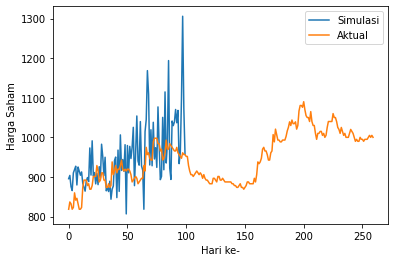

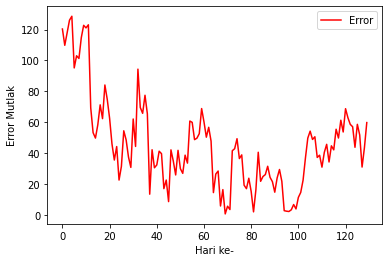

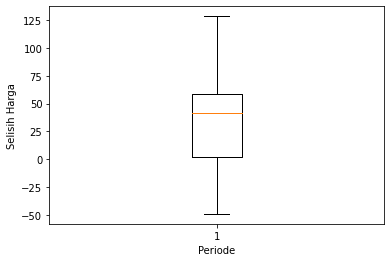

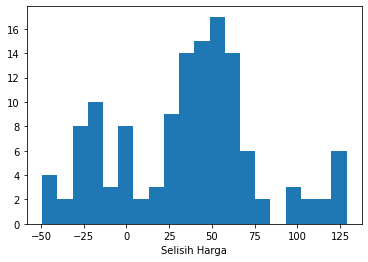

In [ ]:
# Memplot perbandingan harga saham antara simulasi dan aktual empiris
plt.plot(results_emp[:,i], label='Simulasi')
plt.plot(hist['Close'][0:260].values, label='Aktual')
plt.xlabel('Hari ke-')
plt.ylabel('Harga Saham')
plt.legend()
plt.show()

# Memplot error mutlak perbedaan harga antara simulasi dan aktual
plt.plot(np.abs(selisih_emp), 'r', label='Error')
plt.xlabel('Hari ke-')
plt.ylabel('Error Mutlak')
plt.legend()
plt.show()

# Menggambarkan distribusi selisih harga dalam boxplot
plt.boxplot(selisih_emp)
plt.xlabel('Periode')
plt.ylabel('Selisih Harga')
plt.show()

# Menggambarkan distribusi selisih harga dalam histogram
plt.hist(selisih_emp, bins=20)
plt.xlabel('Selisih Harga')
plt.show()

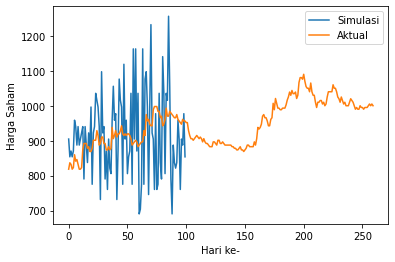

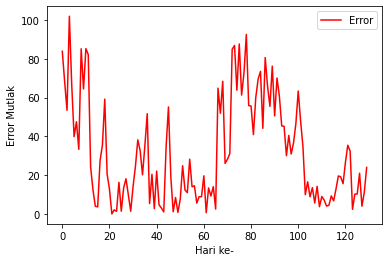

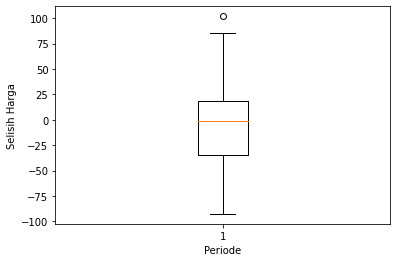

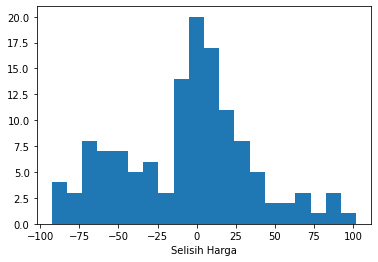

In [ ]:
# Memplot perbandingan harga saham antara simulasi dan aktual CRR
plt.plot(results_crr[:,i], label='Simulasi')
plt.plot(hist['Close'][0:260].values, label='Aktual')
plt.xlabel('Hari ke-')
plt.ylabel('Harga Saham')
plt.legend()
plt.show()

# Memplot error mutlak perbedaan harga antara simulasi dan aktual
plt.plot(np.abs(selisih_crr), 'r', label='Error')
plt.xlabel('Hari ke-')
plt.ylabel('Error Mutlak')
plt.legend()
plt.show()

# Menggambarkan distribusi selisih harga dalam boxplot
plt.boxplot(selisih_crr)
plt.xlabel('Periode')
plt.ylabel('Selisih Harga')
plt.show()

# Menggambarkan distribusi selisih harga dalam histogram
plt.hist(selisih_crr, bins=20)
plt.xlabel('Selisih Harga')
plt.show()

# perbandingan simulai 2 metode

Mean Absolute Error = 45.62357935541174


Text(0.5, 1.0, 'Perbandingan Simulasi Monte Carlo Pendekatan Empiris vs Saham Aktual')

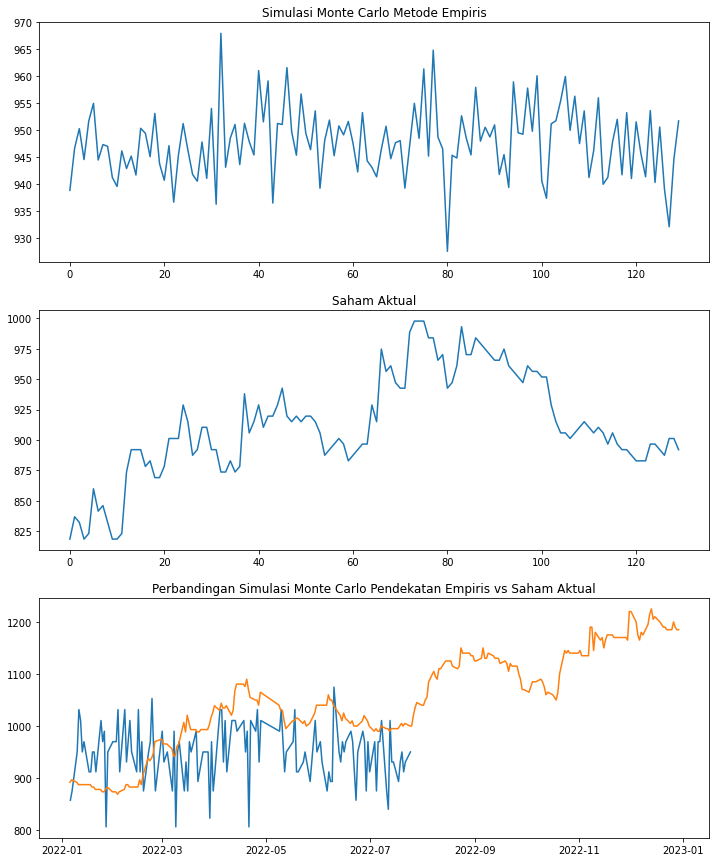

In [ ]:
# Perbandingan hasil simulasi empiris
from sklearn.metrics import mean_absolute_error as mae
rata2Error_emp = mae(hist['Close'][0:130].values, rata2_emp) # mse(nilai original, nilai calculated)
print("Mean Absolute Error =",rata2Error_emp)

fig, ax = plt.subplots(3, figsize=(12,15))
ax[0].plot(rata2_emp)
ax[0].set_title('Simulasi Monte Carlo Metode Empiris')
ax[1].plot(hist['Close'][0:130].values)
ax[1].set_title('Saham Aktual')
ax[2].plot([hist.index.get_level_values(0)[130+x].date() for x in range(0,130)],results_emp[40])
ax[2].plot(hist.Close[130:])
ax[2].set_title('Perbandingan Simulasi Monte Carlo Pendekatan Empiris vs Saham Aktual')

Mean Absolute Error = 31.752964514909177


Text(0.5, 1.0, 'Perbandingan Simulasi Monte Carlo Metode CRR vs Saham Aktual')

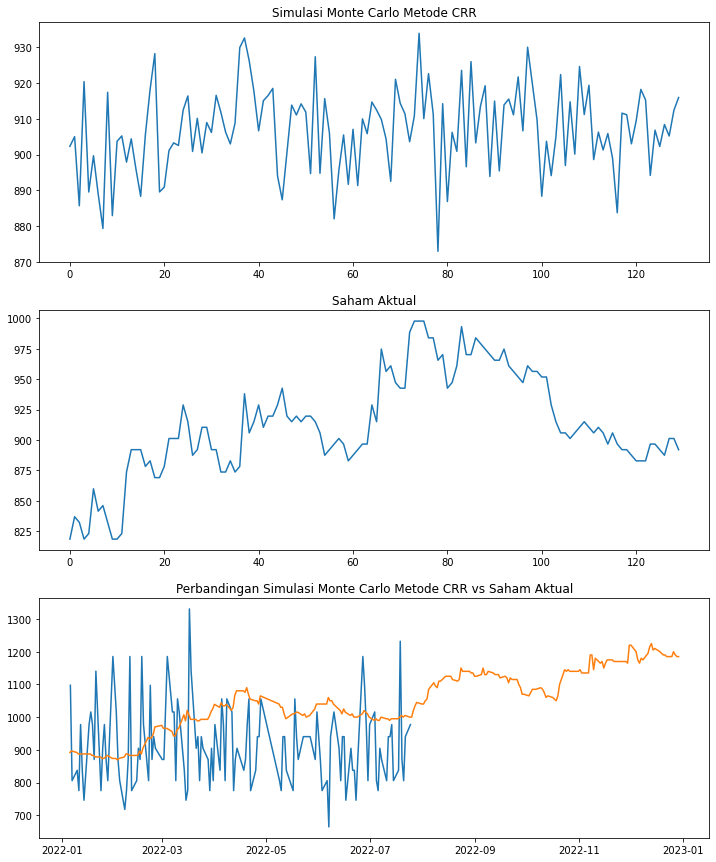

In [ ]:
# perbandingan simulai 2 metode
# Perbandingan hasil simulasi CRR
from sklearn.metrics import mean_absolute_error as mae
rata2Error_crr = mae(hist['Close'][0:130].values, rata2_crr)
print("Mean Absolute Error =",rata2Error_crr)

fig, ax = plt.subplots(3, figsize=(12,15))
ax[0].plot(rata2_crr)
ax[0].set_title('Simulasi Monte Carlo Metode CRR')
ax[1].plot(hist['Close'][0:130].values)
ax[1].set_title('Saham Aktual')
ax[2].plot([hist.index.get_level_values(0)[130+x].date() for x in range(0,130)],results_crr[40])
ax[2].plot(hist.Close[130:])
ax[2].set_title('Perbandingan Simulasi Monte Carlo Metode CRR vs Saham Aktual')

In [ ]:
# Perintah No.9 mencari metode yang lebih dekat dengan data aktual, berdasarkan nilai rata-rata
# error. Kami menggunakan MAE
print("mae crr = ", rata2Error_crr)

if rata2Error_crr < rata2Error_emp:
    print("Bahwa lebih akurat model crr")
elif rata2Error_crr > rata2Error_emp:
    print(None)

print(hist.Close[130:])

mae crr =  31.752964514909177
Bahwa lebih akurat model crr
Date
2022-01-06 00:00:00+07:00     892.010315
2022-01-07 00:00:00+07:00     896.608337
2022-01-10 00:00:00+07:00     892.010315
2022-01-11 00:00:00+07:00     887.412354
2022-01-12 00:00:00+07:00     887.412354
                                ...     
2022-12-26 00:00:00+07:00    1185.000000
2022-12-27 00:00:00+07:00    1200.000000
2022-12-28 00:00:00+07:00    1190.000000
2022-12-29 00:00:00+07:00    1185.000000
2022-12-30 00:00:00+07:00    1185.000000
Name: Close, Length: 243, dtype: float64
